## Project - 1
In this project, we'll build a Neural Network with two hidden layers to classify the images of hand written digits in the MNIST dataset.

<img src="images/neural_net.jpeg">

These two lines of code which will download and read in the data automatically.

In [1]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


Here `mnist` is a lightweight class which stores the training, validation, and testing sets as NumPy arrays. It also provides a function for iterating through data minibatches, which we will use below.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random

# The features are already scaled and the data is shuffled
train_features = mnist.train.images
valid_features = mnist.validation.images
test_features = mnist.test.images

train_labels = mnist.train.labels.astype(np.float32)
valid_labels = mnist.validation.labels.astype(np.float32)
test_labels = mnist.test.labels.astype(np.float32)

The cell below shows the number of images in training set, validation set and testing set.

In [10]:
print(train_features.shape) # 55000 images in training set
print(valid_features.shape) # 5000 images in validation set
print(test_features.shape) # 10000 images in testing set

(55000, 784)
(5000, 784)
(10000, 784)


The next cell has some helper functions to diaplay the images and the corresponding labels.

In [11]:
def display_digit(num):
    print(train_labels[num])
    label = train_labels[num].argmax(axis=0)
    image = train_features[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
def display_mult_flat(start, stop):
    images = train_features[start].reshape([1,784])
    for i in range(start+1,stop):
        images = np.concatenate((images, train_features[i].reshape([1,784])))
    plt.imshow(images, cmap=plt.get_cmap('gray_r'))
    plt.show()

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


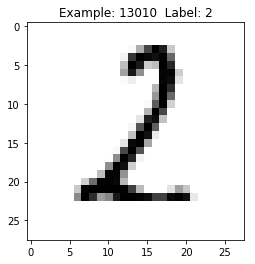

In [12]:
display_digit(random.randint(0, train_features.shape[0]))

Here is what multiple training examples look like to the classifier in their flattened form. Of course, instead of pixels, our classifier sees values from zero to one representing pixel intensity

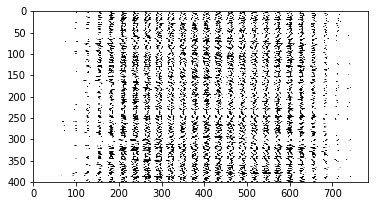

In [15]:
display_mult_flat(0,400)

The next step is importing TensorFlow and defining our session. TensorFlow, in a sense, creates a directed acyclic graph (flow chart) which you later feed with data and run in a session

In [16]:
import tensorflow as tf

Next, we set our hyperparameters. This is basically an iterative process and we experiment with different parameter values. We select the values depending on the final performance of our model.

In [17]:
# set the hyperparameters
learning_rate = 0.001
batch_size = 128
epochs = 10
model_path = "/checkpoints/model.ckpt"

# network parameters
# number of nodes in first hidden layer
n_hidden_1 = 256
# number of nodes in second hidden layer
n_hidden_2 = 256

n_input = 784 # MNIST data input (img shape: 28x28)
n_classes = 10 # MNIST total classes (0-9 digits)

We start building the computation graph by creating nodes for the input images and target output classes.

In [18]:
# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

Here `x` and `y` aren't specific values. Rather, they are each a `placeholder` -- a value that we'll input when we ask TensorFlow to run a computation.

The input images `x` will consist of a 2d tensor of floating point numbers. Here we assign it a shape of `[None, 784]`, where `784` is the dimensionality of a single flattened 28 by 28 pixel MNIST image, and `None` indicates that the first dimension, corresponding to the batch size, can be of any size. The target output classes `y` will also consist of a 2d tensor, where each row is a one-hot 10-dimensional vector indicating which digit class (zero through nine) the corresponding MNIST image belongs to.

The `shape` argument to `placeholder` is optional, but it allows TensorFlow to automatically catch bugs stemming from inconsistent tensor shapes.

Next, we will define the `weights` and `biases`. These two values are the grunt workers of the classifier—they will be the only values we will need to calculate our prediction after the classifier is trained.
We will set their initial values from a `random_normal` probability distribution and TensorFlow will optimize these values later.

In [19]:
# layer weights and bias
weights = {
    'in_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h1_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h2_out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In the next cell, we define a function to create our neural network model. It takes in as parameters, the input images `x`, the `weights` and the `biases`.

Here the function will cretae a network with two hidden layers.
It will return the logits that we'll later feed into the optimizer.

In [20]:
# function to create the model
def neural_network(x, weights, biases):
    # first hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['in_h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    # second hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h1_h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    # output layer with linear activation to get logits
    output = tf.matmul(layer_2, weights['h2_out']) + biases['out']
    
    return output

`print_stats` is a helper function to print some network stats during training.

It will print out the `cost (error)` and `accuracy` of the network after each epoch.

In [21]:
def print_stats(epoch_i, sess, last_features, last_labels):
    # print cost and validation accuracy of an epoch
    current_cost = sess.run(cost,
                           feed_dict={x: last_features, y: last_labels})
    
    valid_accuracy = sess.run(accuracy, 
                             feed_dict={x: valid_features, y: valid_labels})
    
    print('Epoch: {:<3} - Cost: {:<6.3} Valid Accuracy: {:<5.3}'.format(epoch_i, 
                                                                        current_cost, 
                                                                        valid_accuracy))

Next up, we define our `cost` function and the `optimizer` we want to use.

In [22]:
# construct model
predictions = neural_network(x, weights, biases)

# define loss and the optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

# saver operator to save all the variables
saver = tf.train.Saver()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [23]:
# calculate accuracy
correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [24]:
with tf.Session() as sess:
    # Initialize all the variables
    sess.run(init)
    
    # Training cycles
    for epoch in range(epochs):
        total_batches = int(mnist.train.num_examples/batch_size)
        # loop over all the batches
        for i in range(total_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # run optimizer
            opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            
        # display the stats
        print_stats(epoch, sess, batch_x, batch_y)
        
    save_path = saver.save(sess, model_path)
    print("\nModel saved in: %s" %save_path)

Epoch: 0   - Cost: 1.17e+02 Valid Accuracy: 0.804
Epoch: 1   - Cost: 42.2   Valid Accuracy: 0.845
Epoch: 2   - Cost: 27.6   Valid Accuracy: 0.864
Epoch: 3   - Cost: 28.3   Valid Accuracy: 0.873
Epoch: 4   - Cost: 25.4   Valid Accuracy: 0.884
Epoch: 5   - Cost: 47.0   Valid Accuracy: 0.884
Epoch: 6   - Cost: 12.1   Valid Accuracy: 0.892
Epoch: 7   - Cost: 17.2   Valid Accuracy: 0.894
Epoch: 8   - Cost: 7.31   Valid Accuracy: 0.898
Epoch: 9   - Cost: 20.0   Valid Accuracy: 0.901

Model saved in: /checkpoints/model.ckpt


In [25]:
with tf.Session() as sess:
    # Initialize the variables
    sess.run(init)
    
    # restore the model weights from the saved model
    load_path = saver.restore(sess, model_path)
    print("Model restored from: %s" %save_path)
    
    # calculate the final test accuracy
    test_accuracy = sess.run(accuracy, feed_dict={x: test_features,
                                                 y: test_labels})
    
    print('\nTest Accuracy: {}'.format(test_accuracy))

INFO:tensorflow:Restoring parameters from /checkpoints/model.ckpt
Model restored from: /checkpoints/model.ckpt

Test Accuracy: 0.9027000069618225
